In [1]:
##CONSTRUCTION MODEL FOR PINHIBENS DSM17395

#importing packages
from cobra.io import read_sbml_model, write_sbml_model, save_json_model
import numpy as np

In [2]:
#creating model from NCBI database
!carve --fbc2 --refseq GCF_000154765.2 -o pinhibens_DSM17395.xml
model = read_sbml_model('pinhibens_DSM17395.xml')

Traceback (most recent call last):
  File "/Users/marta/opt/anaconda3/bin/carve", line 5, in <module>
    from carveme.cli.carve import main
  File "/Users/marta/opt/anaconda3/lib/python3.8/site-packages/carveme/__init__.py", line 14, in <module>
    set_default_solver(config.get('solver', 'default_solver'))
  File "/Users/marta/opt/anaconda3/lib/python3.8/site-packages/reframed/solvers/__init__.py", line 60, in set_default_solver
    raise RuntimeError(f"Solver {solvername} not available.")
RuntimeError: Solver cplex not available.


In [3]:
#gap filling the model with rich medium (LB)

In [4]:
%%time
!carve --refseq GCF_000154765.2 --output pinhibens_DSM17395_LB.xml --gapfill LB --init LB

Traceback (most recent call last):
  File "/Users/marta/opt/anaconda3/bin/carve", line 5, in <module>
    from carveme.cli.carve import main
  File "/Users/marta/opt/anaconda3/lib/python3.8/site-packages/carveme/__init__.py", line 14, in <module>
    set_default_solver(config.get('solver', 'default_solver'))
  File "/Users/marta/opt/anaconda3/lib/python3.8/site-packages/reframed/solvers/__init__.py", line 60, in set_default_solver
    raise RuntimeError(f"Solver {solvername} not available.")
RuntimeError: Solver cplex not available.
CPU times: user 16.7 ms, sys: 16.1 ms, total: 32.8 ms
Wall time: 1.16 s


In [5]:
model = read_sbml_model('pinhibens_DSM17395_LB.xml')

In [6]:
#solving problems about the SBML file -it was missing "boundaryCondition="false""
for met in model.metabolites:
    met.boundaryCondition = "false"

In [7]:
#creating new file so the SBML problem is fixed
write_sbml_model(model, "pinhibens_DSM17395_ok.xml")
model = read_sbml_model('pinhibens_DSM17395_ok.xml')

In [8]:
##CONSTRUCTION AND HIGH-LEVEL ANALYSIS OF STOICHIOMETRIC MATRIX (S)

#creating the stoichiometric matrix from the model and cheching how sparse it is:
from cobra.util import create_stoichiometric_matrix

In [9]:
S=create_stoichiometric_matrix(model)
S.shape

(1722, 2563)

In [10]:
nonzeros=np.count_nonzero(S)
zeros=S[np.where(S == 0)].size
percent_nonzeros=(nonzeros/(zeros+nonzeros))*100
print("Number of Zeroes in S -->",zeros)
print("Number of non-Zeroes in S -->",nonzeros)
print("Percentage of non-zero elements in S-->",round(percent_nonzeros,2),"%")

Number of Zeroes in S --> 4402733
Number of non-Zeroes in S --> 10753
Percentage of non-zero elements in S--> 0.24 %


In [11]:
#finding the degrees of freedom (F) of our model
from numpy.linalg import matrix_rank

In [12]:
rank_S=matrix_rank(S, tol=None, hermitian=False)
dimS=S.shape
F=dimS[1]-rank_S
print("Degrees of freedom:",F)

Degrees of freedom: 893


In [13]:
#visualization of stoichiometric matrix (S)

import matplotlib.pyplot as plt

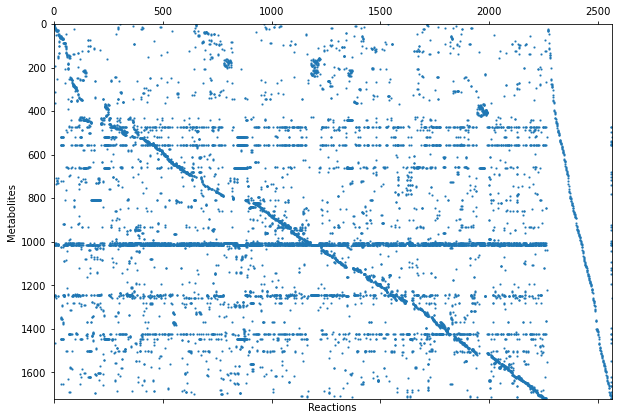

In [14]:
plt.figure(figsize=(10,10))
plt.spy(S, precision=0.01, markersize=1)
plt.xlabel('Reactions')
plt.ylabel('Metabolites')
plt.show()

In [15]:
##COMPUTE REACTION AND COMPOUND ADJACENCY MATRICES

#construction of binary S


In [16]:
Sb=np.where(S!=0,1,S)

In [17]:
#compute the reaction (A_v) and compound (A_x) adjacency matrices

In [18]:
A_v=Sb.T.dot(Sb)


In [19]:
A_x=Sb.dot(Sb.T)

In [20]:
#finding metabolite involved in the largest number of reactions
D_ax=A_x.diagonal()  #We create a new vector that only includes the diagonal information ex. ATP.vs.ATP, etc.

D_ax.max() #We get the maximum value of the diagonal for A_x
D_ax.argmax() #We get the position where the maximum value of A_x is

model.metabolites[D_ax.argmax()]  #we index on the model the position we are interested in

<Metabolite h_c at 0x7fc5ed26a9d0>

In [21]:
#extracting the top10 most connected metabolites of the model:
connectivity = sorted(zip(model.metabolites, A_x.diagonal()), key=lambda item: item[1], reverse=True)
connectivity[0:10]

topconnect=connectivity[0:10]

u=0
topelements=[]
for element in topconnect:
    topelements.append(topconnect[u][0].id) #Loop gives me the id for each element of topconnect list, and it adds it to u.
    u=u+1 #append means "add afterwards"
print("Top10 connected metabolites:", topelements)

Top10 connected metabolites: ['h_c', 'h2o_c', 'atp_c', 'pi_c', 'adp_c', 'coa_c', 'nad_c', 'nadh_c', 'ppi_c', 'h_p']


In [22]:
#finding the reactions involved with the metabolite "10fthf_c":

listr=list(model.metabolites.get_by_id('10fthf_c').reactions)

In [23]:
u=0
ids=[]
for element in listr:
    ids.append(listr[u].id)
    u=u+1 #append means "add afterwards"

print("Reactions involved with 10fthf_c:",ids)

Reactions involved with 10fthf_c: ['MTHFC', 'Growth', 'AICART', 'GARFT', 'FTHFLi']


In [24]:
##GENERATE NETWORKS FROM THE ADJACENCY MATRICES
import networkx as nx

In [25]:
#create a metablolite (A_x) centric network
compound_centric_network = nx.from_numpy_matrix(A_x)

In [26]:
mapping = dict(zip(range(0, len(model.metabolites)), model.metabolites)) #naming the nodes in the network after the metabolites in the model
compound_centric_network = nx.relabel_nodes(compound_centric_network, mapping)

In [27]:
#finding the number of connections (degree) each node (compound) has
metabolite_degrees = compound_centric_network.degree()

In [28]:
sorted_metabolite_degrees = sorted(metabolite_degrees, key=lambda item: item[1], reverse=True)
sorted_metabolite_degrees[0:10]

[(<Metabolite h_c at 0x7fc5ed26a9d0>, 1301),
 (<Metabolite h2o_c at 0x7fc5ed26a550>, 1035),
 (<Metabolite atp_c at 0x7fc5ed242f70>, 723),
 (<Metabolite pi_c at 0x7fc5ed28cc40>, 605),
 (<Metabolite adp_c at 0x7fc5e4ec5fd0>, 567),
 (<Metabolite nad_c at 0x7fc5ed27e820>, 361),
 (<Metabolite ppi_c at 0x7fc5ed2903a0>, 331),
 (<Metabolite nadh_c at 0x7fc5ed27e880>, 326),
 (<Metabolite coa_c at 0x7fc5ed24b430>, 315),
 (<Metabolite h_p at 0x7fc5ed26abe0>, 272)]

In [29]:
#FIND REACTION
print(model.objective)

Maximize
1.0*Growth - 1.0*Growth_reverse_699ae


In [30]:
model.reactions.Growth.metabolites

{<Metabolite 10fthf_c at 0x7fc5ed165b80>: -0.000223,
 <Metabolite ala__L_c at 0x7fc5ed23e790>: -0.513689,
 <Metabolite amet_c at 0x7fc5ed23eeb0>: -0.000223,
 <Metabolite arg__L_c at 0x7fc5ed242640>: -0.295792,
 <Metabolite asn__L_c at 0x7fc5ed242970>: -0.241055,
 <Metabolite asp__L_c at 0x7fc5ed242ee0>: -0.241055,
 <Metabolite atp_c at 0x7fc5ed242f70>: -54.124831,
 <Metabolite ca2_c at 0x7fc5ed245bb0>: -0.005205,
 <Metabolite cl_c at 0x7fc5ed2482e0>: -0.005205,
 <Metabolite coa_c at 0x7fc5ed24b430>: -0.000576,
 <Metabolite cobalt2_c at 0x7fc5ed24b460>: -0.0001,
 <Metabolite ctp_c at 0x7fc5ed24bc70>: -0.133508,
 <Metabolite cu2_c at 0x7fc5ed24bcd0>: -0.000709,
 <Metabolite cys__L_c at 0x7fc5ed24bf10>: -0.09158,
 <Metabolite datp_c at 0x7fc5ed2507c0>: -0.026166,
 <Metabolite dctp_c at 0x7fc5ed250af0>: -0.027017,
 <Metabolite dgtp_c at 0x7fc5ed250df0>: -0.027017,
 <Metabolite dttp_c at 0x7fc5ed253460>: -0.026166,
 <Metabolite fad_c at 0x7fc5ed258a00>: -0.000223,
 <Metabolite fe2_c at 0x7f

In [31]:
write_sbml_model(model, "ok_model.xml")

In [32]:
#DRAWING OF THE PATHWAY OF CENTAL CARBON METABOLISM

In [33]:
copy_model=model

In [34]:
copy_model.optimize()

<Solution 0.709 at 0x7fc5e6dc6910>

In [35]:
copy_model.optimize().objective_value

0.7087835138069689

In [36]:
solution=copy_model.optimize()

In [37]:
solution.fluxes

12DGR140tipp    0.000000
12DGR160tipp    0.000000
12DGR180tipp    0.000000
12DGR181tipp    0.000000
13PPDH          0.000000
                  ...   
EX_xyl__D_e     0.000000
EX_zn2_e       -0.000242
Growth          0.708784
ATPM            0.000000
ASNS2           0.170856
Name: fluxes, Length: 2563, dtype: float64

In [38]:
solution.fluxes[solution.fluxes != 0.] #finding the non-zero fluxes

2S6HCCi        7.087835e-05
AACOAR_syn     7.494005e-16
ABTA           2.220446e-15
ACALD         -2.811527e+00
ACALDt        -2.811935e+00
                   ...     
EX_trp__L_e   -4.028938e-02
EX_tyr__L_e   -9.773841e-02
EX_zn2_e      -2.416952e-04
Growth         7.087835e-01
ASNS2          1.708558e-01
Name: fluxes, Length: 304, dtype: float64

In [39]:
save_json_model(model, "pinhibens_DSM17395_ok_2.json")

In [44]:
import escher
from escher import Builder
import cobra
from time import sleep

In [57]:
builder = Builder(
    model_json='pinhibens_DSM17395_ok_2.json'
)

In [55]:
print (builder) #on "Map" select "load map JSON" and then look for the file "Central metabolism.json"

Builder()

In [ ]:
###Testing GSM model against data

In [ ]:
#first we will make a copy_model using GM as a medium
#secondly we will set the glucose uptake to 0.13
#thirdly we will check the O2, CO2 and growth rates to check if data matches.

In [ ]:
#Search engine:
search1=input("What do you want to look for: reactions or  metabolites?\n Type in 'Reactions' or 'Metabolites'.\n")
search2=input("Are you looking for a formula? Y/N \n")
search3=input("Search for (case sensitive):\n")
found1=False
if search1=="Metabolites":
        for metabolite in model.metabolites:
            if search2=="N":
                if search3 in metabolite.name:
                    print("ID:",metabolite.id,"Name:",metabolite.name,"Formula:",metabolite.formula)
                    found1=True
                elif search3 in metabolite.id:
                    print("ID:",metabolite.id,"Name:",metabolite.name,"Formula:",metabolite.formula)
                    found1=True
            if search2=="Y":
                if search3 in metabolite.formula:
                    print("Formula:",metabolite.formula,"ID:",metabolite.id,"Name:",metabolite.name)
                    found1=True
elif search1=="Reactions":
        for reaction in model.reactions:
            if search3 in reaction.name:
                print("ID:",reaction.id,"Name:",reaction.name)
                found1=True
            elif search3 in reaction.id:
                print("ID:",reaction.id,"Name:",reaction.name)
                found1=True
if found1==False:
    print("Not found in model. Tip: Python is case sensitive.")
    print("Not found in model. Tip: Python is case sensitive.")